In [1]:
'''
EXPERIMENTS ON BEH2
'''

from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
import numpy as np
import matplotlib.pyplot as plt
import time
from functools import partial
from collections import Counter
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp
from modified_derandomization import modified_derandomized_classical_shadow



# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -19.04

# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="Be 0 0 0; H 0 0 1.3264; H 0 0 -1.3264",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
num_particles = problem.num_particles
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)
#print(bkenc_hamiltonian)


hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])



hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
#for weight, term in zip(weights, hamiltonian_terms_XYZE):
#    print(weight, term)


reps = 1

ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)

'''
Define the cost function
'''

backend = QasmSimulator(method='statevector', shots=1)


# Create circuit with just the randomised basis change operators
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.h(idx)
        elif op == 'Y':
            rand_meas.h(idx)
            rand_meas.p(-np.pi/2, idx)
        elif op == 'Z':
            rand_meas.id(idx)
    return rand_meas


def objective_function(operators, params):
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in operators)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                snapshot.reverse()
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    
    cost = 0.0
    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)
            
        
    cost_history.append(cost)
    
    return cost


/home2/Renata/.conda/envs/py2023/lib/python3.7/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


Overgenerated operators
 Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 49766, ('X', 'X', 'X', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'X'): 56, ('X', 'X', 'X', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'Z'): 15, ('Z', 'Z', 'X', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'Z'): 14, ('Z', 'X', 'X', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'Z'): 13, ('X', 'X', 'Z', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'Z'): 13, ('X', 'Y', 'Z', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'Z'): 12, ('X', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'Z', 'Z'): 9, ('Z', 'X', 'X', 'X', 'X', 'Y', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'Z', 'Z'): 4, ('Z', 'Z', 'X', 'Z', 'X', 'X', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 3, ('X', 'X', 'Z', 'X', 'Z', 'Z', 'Z', 'Z', 'Z', 'X', 'Z', 'X', 'X', 'Z'): 3, ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 2, ('X', 'X', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'X', 'Z', 

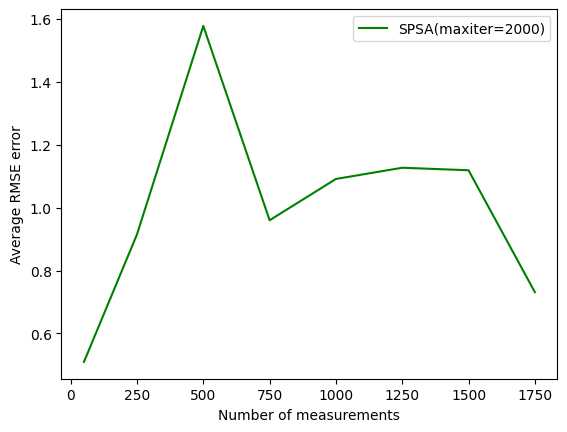

In [2]:
 '''
TESTING WITH OVERGENERATED OPERATORS: SELECTING A DIFFERENT SUBSET OF OPERATORS
'''

start_time = time.time()
rmse_errors = []


import random

# generate 50K operators, then remove the most common ones till we reach the required number
overgenerated_derandomized_operators = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 50000, 
                                                                      system_size, weight=abs_weights)


tuples = (tuple(pauli) for pauli in overgenerated_derandomized_operators)
overgenerated_counts = Counter(tuples)
print('Overgenerated operators\n', overgenerated_counts)

measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

reduced_schemes = []
for num_operators in measurement_range:
    operators = random.choices(list(overgenerated_counts.keys()), 
                               weights=[1/weight for weight in overgenerated_counts.values()], k=num_operators)
    reduced_schemes.append(operators)
    
    
    
print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')

for operators in reduced_schemes:   

    counts = Counter(tuple(pauli) for pauli in operators)
    
    optimizer = SPSA(maxiter=2000) 
    cost_function = partial(objective_function, operators)
    
    expectation_values = []
    num_experiments = 3


    for iteration in range(num_experiments):
        
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))

    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - EXPECTED_EIGENVALUE)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(len(operators), counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'g', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)
